# Iterative results

In [183]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc, roc_auc_score


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR


from fault_management_uds.config import rain_gauge_color, condition_to_meta
from fault_management_uds.plots import visualize_indicator_dict
from fault_management_uds.plots import pca_plot, visualize_metric_matrix, visualize_confusion, visualize_roc_auc




In [2]:
indicator_2_data_label = json.load(open(REFERENCE_DIR / 'indicator_2_data_label.json', 'r'))

In [3]:

data_types = ["train", "val", "test"]

data_type = "test"

In [4]:
# load iterations folders
save_folder = "transformer/7_anomalous"
save_folder = MODELS_DIR / save_folder
prefix = "iteration="

relative_path = "1_split/anomalous"

filename = 'anomaly_prediction_results.pkl'


In [44]:
def extract_outputs(outputs):

    # get the model predictions

    idx_pred_0 = outputs['0']
    label_0 = np.zeros(len(idx_pred_0), dtype=int)
    idx_pred_1 = outputs['1']
    label_1 = np.ones(len(idx_pred_1), dtype=int)

    # align these predictions with the true labels
    idx_pred = np.concatenate((idx_pred_0, idx_pred_1))
    label_pred = np.concatenate((label_0, label_1))

    # sort the predictions
    sort_indices = np.argsort(idx_pred)
    idx_pred = idx_pred[sort_indices]
    label_pred = label_pred[sort_indices]

    decision_function = outputs["decision_function"]


    # get the true labels
    data_label = outputs["data_label"]
    actual = np.array([int(dl != 'Original') for dl in data_label])



    return label_pred, decision_function, actual, data_label
#idx_pred, label_pred, decision_function, true, data_label

In [45]:

runs = os.listdir(save_folder)
runs = [run for run in runs if run.startswith(prefix)]
print(f"Total: {len(runs)}")
# take ceil of log2 of the number of runs to get the highest iteration
n_iterations = int(np.ceil(np.log2(len(runs))))
print(f"Highest iteration: {n_iterations}")

print(runs)

combined_results = {
}

for iteration in range(n_iterations):
    combined_results[iteration] = {}

results = {}


for run in runs:
    # get the iteration number
    iteration_identifier = run.split("=")[-1].split("_")[0]
    n_iteration = len(iteration_identifier.split("."))
    if n_iteration > 2:
        # go to next iteration
        continue
    print(f"Iteration identifier: {iteration_identifier}")
    print(f"Number of iteration: {n_iteration}")

    # load the outputs file
    outputs_file = save_folder / run / relative_path / data_type / filename
    outputs = pd.read_pickle(outputs_file)

    label_pred, decision_function, actual, data_label = extract_outputs(outputs)

    results[iteration_identifier] = {
        "label_pred": label_pred,
        "decision_function": decision_function,
        "actual": actual,
        "data_label": data_label
    }
    # note:
    # - label_pred
    #del outputs
    #break
    print('')


Total: 7
Highest iteration: 3
['iteration=0_250106_0752', 'iteration=0.1_250107_1455', 'iteration=0.1.0_250108_2222', 'iteration=0.0.1_250108_2105', 'iteration=0.0_250107_1459', 'iteration=0.1.1_250108_2117', 'iteration=0.0.0_250108_2052']
Iteration identifier: 0
Number of iteration: 1

Iteration identifier: 0.1
Number of iteration: 2

Iteration identifier: 0.0
Number of iteration: 2



In [55]:
sorted(['0.0.0', '0.0.1', '0.1.0', '0.1.1'])

['0.0.0', '0.0.1', '0.1.0', '0.1.1']

In [162]:
# create a combined results where it is not iterations, concatenate the results
combined_results = {}
ano_pred_timeline = {}

iterations = ['1', '2']

colormap = {
    0: 'blanchedalmond',
    1: 'slateblue',
    }

iter_to_keys = {}

iter_keys = list(results.keys())
for iteration in iterations:
    # find relevant keys
    relevant_keys = [key for key in iter_keys if len(key.split(".")) == int(iteration)]
    # sort keys so that 0 then 1
    relevant_keys = sorted(relevant_keys)
    iter_to_keys[iteration] = relevant_keys
    print(f"Relevant keys: {relevant_keys}")
    # concatenate the results
    combined_results[iteration] = {}
    ano_pred_timeline['Iteration ' + iteration] = {
        'colormap': colormap,
    }
    for key in relevant_keys:
        # concatenate the results
        combined_results[iteration]["label_pred"] = np.concatenate((combined_results[iteration].get("label_pred", []), results[key]["label_pred"]))
        combined_results[iteration]["decision_function"] = np.concatenate((combined_results[iteration].get("decision_function", []), results[key]["decision_function"]))
        combined_results[iteration]["actual"] = np.concatenate((combined_results[iteration].get("actual", []), results[key]["actual"]))
        combined_results[iteration]["data_label"] = np.concatenate((combined_results[iteration].get("data_label", []), results[key]["data_label"]))

        # create timeline data: sort label_pred
        ano_pred_timeline['Iteration ' + iteration]['indicator'] = np.concatenate((ano_pred_timeline['Iteration ' + iteration].get('indicator', []), sorted(results[key]["label_pred"])))


Relevant keys: ['0']
Relevant keys: ['0.0', '0.1']


## The data split sizes

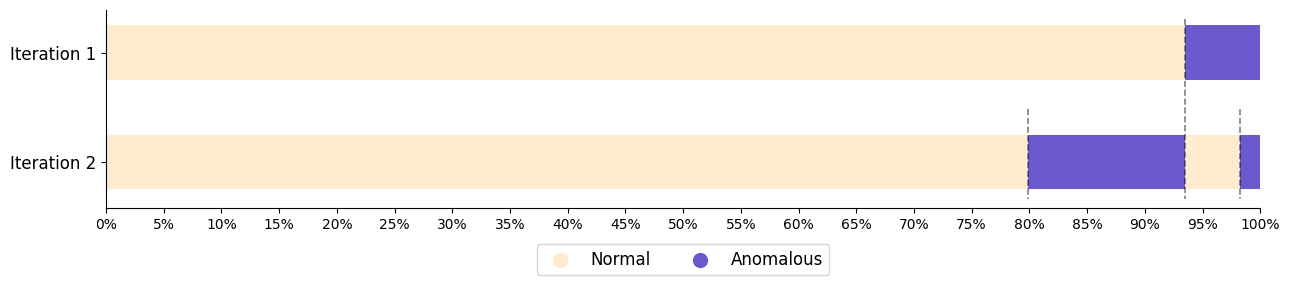

In [176]:
# indicator plot
fig, ax = plt.subplots(figsize=(13, 3)) 

# predicted anomalies in each subset
ax = visualize_indicator_dict(ax, ano_pred_timeline, start=None, end=None, adjust='half-point', ylabel='')
ax.set_xlim(0, len(ano_pred_timeline['Iteration 1']['indicator']))
total_length = len(ano_pred_timeline['Iteration 1']['indicator'])
xticks = np.linspace(0, total_length - 1, num=21, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{round(x / total_length * 100)}%" for x in xticks])
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)#; ax.spines['left'].set_visible(False)
# increase y-ticks font size
ax.tick_params(axis='y', labelsize=12)


ymin, ymax = ax.get_ylim()
diff = abs(ymax - ymin)
ignore = [-100] # dummy value to not be empty
for iter in iterations:    
    # find the indices where we go from 0 to 1 or 1 to 0
    indices = np.where(np.diff(ano_pred_timeline['Iteration ' + iter]['indicator']) != 0)[0]
    # show decision boundaries
    i=0
    for idx in indices:
        if min([abs(idx - x) for x in ignore]) < 10:
            continue
        ax.vlines(idx, 1.3375-diff/int(iter), 1.3375, color='black', linestyle='--', alpha=0.5, linewidth=1.2)
        # add text
        #ax.text(idx, 1.3375-diff/int(iter), f'{iter_to_keys[iter][i]}', color='dimgray', ha='center', va='bottom', fontsize=12)
        ignore.append(idx)
        i += 1
        
# add legend based on colormap
for i, (key, value) in enumerate(colormap.items()):
    ax.scatter([], [], color=value, label=str(key).replace('0', 'Normal').replace('1', 'Anomalous'), s=100)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), ncol=len(colormap), fontsize=12)

plt.tight_layout()
plt.show()


## The AUC scores

In [180]:
hue_map = {
    'Overall': 'blanchedalmond', 
    'Spike': 'OrangeRed',
    'Noise': 'DarkGray',
    'Frozen': 'SteelBlue',
    'Offset': 'Gold',
    'Drift': 'LightSeaGreen',
}
hue_order = list(hue_map.keys())[::-1]

In [189]:
combined_results[iter].keys()

dict_keys(['label_pred', 'decision_function', 'actual', 'data_label'])

In [190]:
len(combined_results[iter]['actual']), len(combined_results[iter]['decision_function'])#[mask])

(866819, 866819)

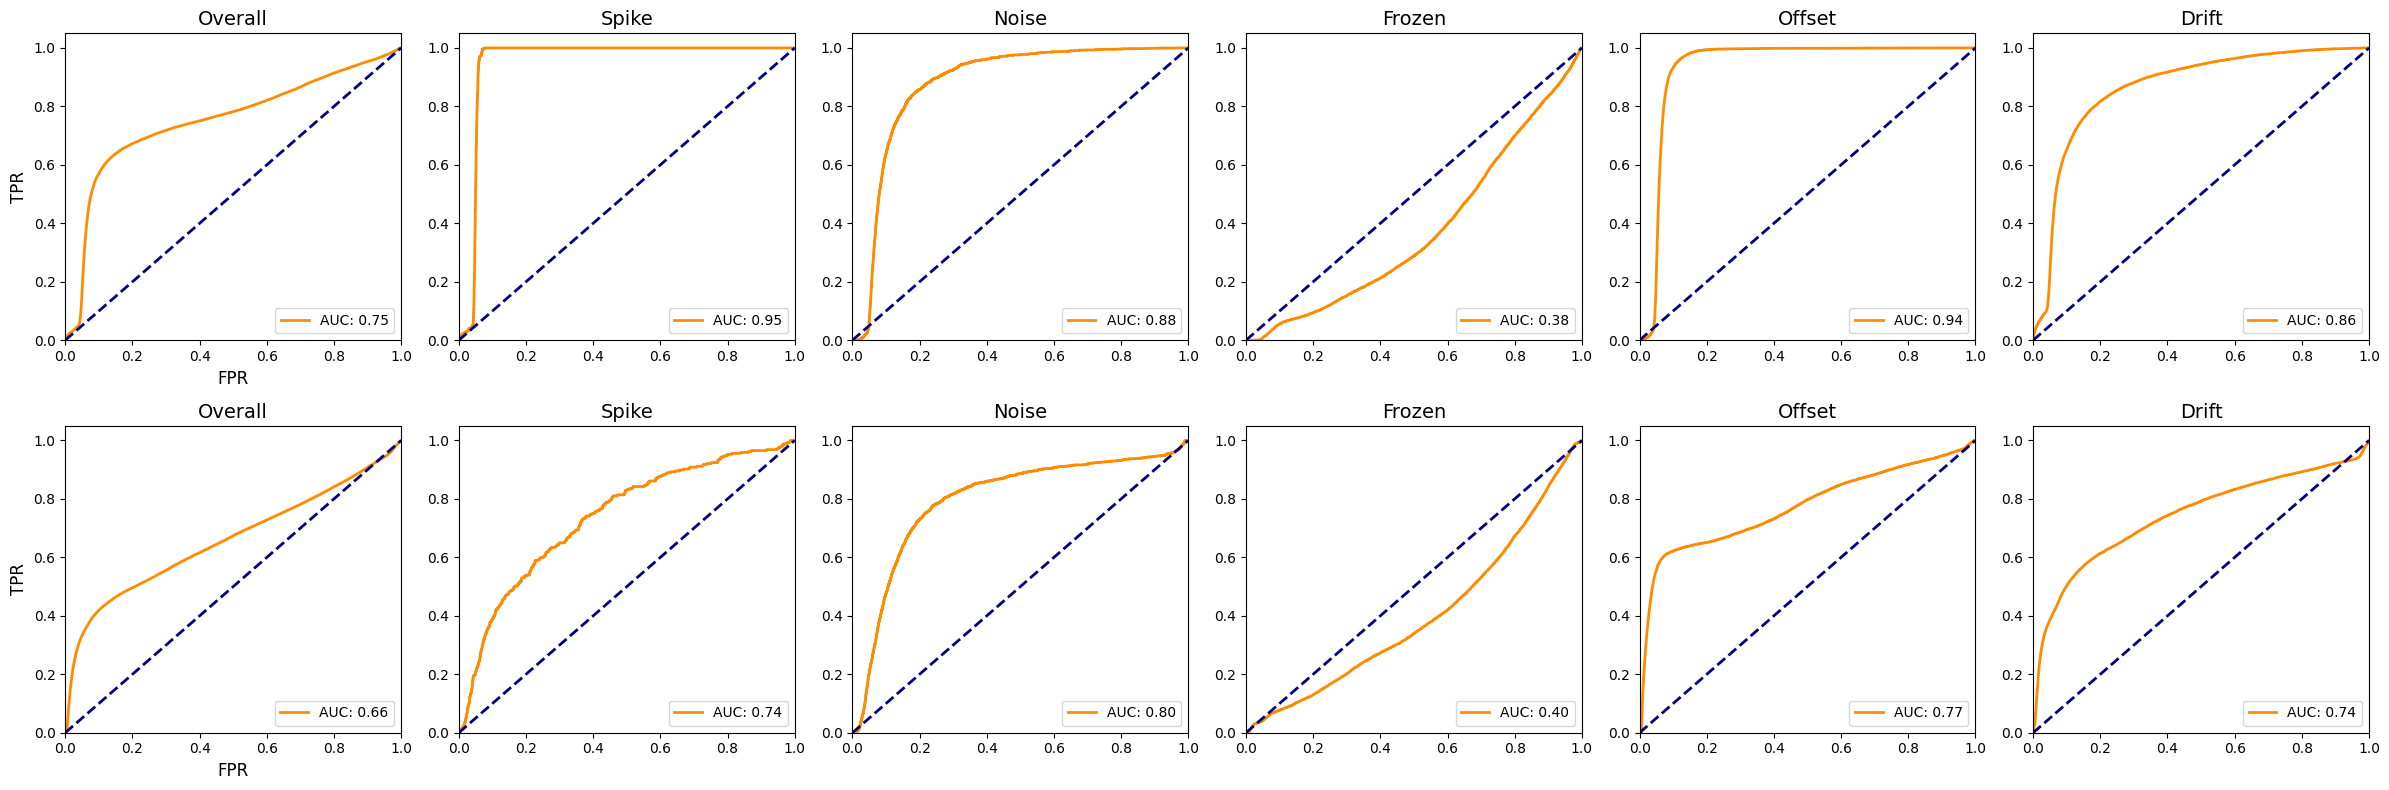

In [195]:
n_rows = len(combined_results)
n_cols = len(hue_order)
# create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))


for i, iter in enumerate(combined_results):
    actual = combined_results[iter]['actual']
    data_label = combined_results[iter]['data_label']
    decision_function = combined_results[iter]['decision_function'] 
    for j, label in enumerate(hue_order[::-1]):
        if label == 'Overall':
            # set mask to all the data
            mask = np.ones(len(actual), dtype=bool)
        else:
             # set mask to the label and original
             mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')

        #print(f'Anomaly: {label}')
        # ROC curve
        fpr, tpr, _ = roc_curve(actual[mask], decision_function[mask])
        roc_auc = auc(fpr, tpr)
        # def visualize_roc_auc(ax, i, key, fpr, tpr, roc_auc):
        axes[i, j] = visualize_roc_auc(axes[i, j], j, label, fpr, tpr, roc_auc)



plt.tight_layout()
plt.show()

## Matrix of metrics

rows are iterations, columns are metrics